# PLAsTiCC time series classification
This is a ML code that performs classification of the time series from the Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC; https://www.kaggle.com/c/PLAsTiCC-2018). A sample representation of the data is provided after loading the data.

Labels are provided for the training set.

The steps are the following: <br>
1. Import libraries and sample
2. Split sub-samples (training, validation, testing)
3. Fit with various classifier and check performance
4. Compare various classifiers in testing sample

The alternative classifiers provide first guesses on the expected accuracy

## Loading Data

In [1]:
# Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets, utils, metrics
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
path_to_data = "/data/deep_learning/database_PLAsTiCC/training_data_v1"

In [3]:
import glob
files = sorted(glob.glob(path_to_data + "/*.npy"))


# > Loading series / labels:
# <indexed as ID array>

# restore: n_files = len(files)
n_files = 100

IDs   = []
# ID number (without "id-")
bands = []
# band name (without "band-") [0 .. 5]

series = []
labels = []

data_uneven = []
# list of data <image(x,y), band>
# NOTE: the images in data can have different sizes
#       Filled by one file per entry, independently from ID

Duration_MJDs = []
# array of duration of light curves

for i in range(n_files):

    tmp = np.load(files[i])

    IDs.append(files[i].split("/")[-1].split("_")[0].strip("id-"))
    bands.append(int(files[i].split("/")[-1].split("_")[1].strip("band-")))

    band = int(bands[-1])
    # current band index [0 .. 6]
    
    series.append(tmp)
    labels.append(files[i].split("/")[-1].split("-")[-1].strip(".npy"))

    
    # > Loading single data files:
    #
    # Data format:
    #
    # Modified Juilian Date, Flux, err_Flux, Detected (flag)

    MJD = series[-1][:,0]
    # Modified Julian Date
    
    F = series[-1][:,1]
    # flux
    
    F_err = series[-1][:,2]
    # flux error
    
    
    Duration_MJDs.append(MJD[-1] - MJD[0])

    # > Converting data into a matrix of flux "ratios"
    #
    #   [1             , (F_1 / F_2)  , ..       , ..       , (F_1 / F_N)  ]
    #   [(F_2 / F_1)   , 1            , ..       , ..       , (F_2 / F_N)  ]
    #   [..            , ..           , 1        , ..       , ..           ]
    #   [(F_N-1 / F_1) , ..           , ..       , 1        , (F_N-1 / F_N)]
    #   [(F_N / F_1)   , ..           , ..       , ..       , 1            ]

    
    data_i = np.zeros((len(MJD),len(MJD),6))
    # flux ratio matrix for source i
    # NOTE: organizing data in a 2D matrix with shape [ len(array) ,  len(array) , channels(= n_bands) ]

    
    for j in range(len(MJD)):
    # j = row index
      
        data_i[j,:,band] = ( F[j] / F )

              
    # > Mirroring matrix across the diagonal:
    data_i_band = data_i[:,:,band]
    indexes_lower = np.tril_indices(data_i_band.shape[0], -1)
    # indexes of lower part of matrix
    data_i_band[indexes_lower] = data_i_band.T[indexes_lower]
    # mirroring
    
    data_i[:,:,band] = data_i_band

    data_uneven.append((data_i[:,:,band] , band))


data_uneven = np.array(data_uneven)
    
Duration_MJDs = np.array(Duration_MJDs)


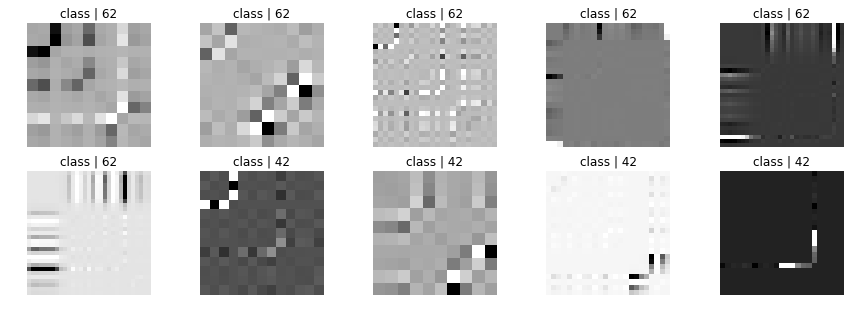

In [4]:
# Display some example images of galaxies
images_bands_and_labels = list(zip(data_uneven, labels))

fig = plt.figure(figsize=(15,5))
for index in range(10):
    
    image = images_bands_and_labels[index][0][0]
    label = images_bands_and_labels[index][1]
    
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, vmin=0.5*np.min(image), vmax=0.8*np.max(image), interpolation='nearest')
    plt.title('class | ' + label)

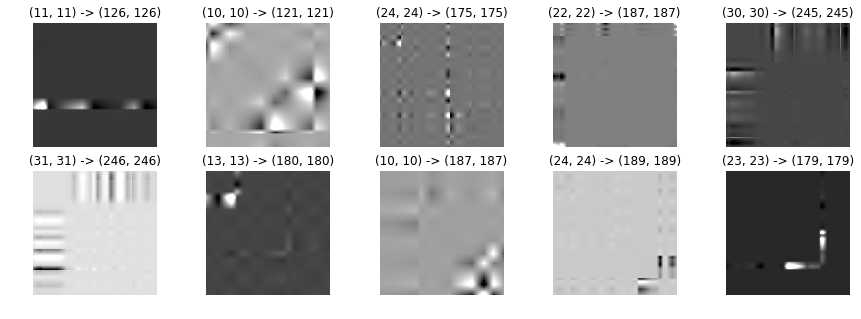

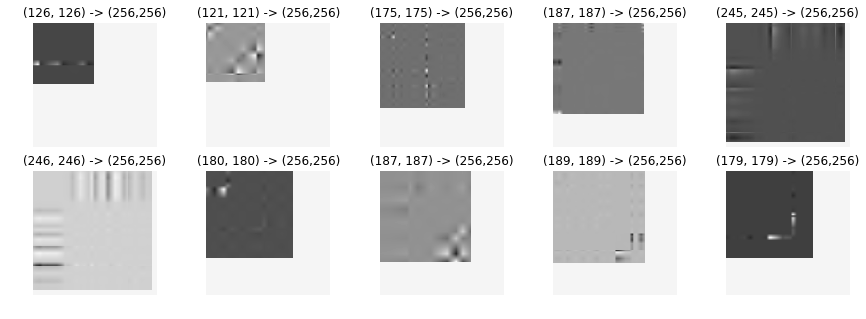

In [5]:
from scipy import interpolate

'''
Interpolation Example.

mymin,mymax = 0,3
X = np.linspace(mymin,mymax,4)
Y = np.linspace(mymin,mymax,4)

x,y = np.meshgrid(X,Y)

test = np.array([[ 1.2514318 ,  1.25145821,  1.25148472,  1.25151133],
       [ 1.25087456,  1.25090105,  1.25092764,  1.25095435],
       [ 1.25031581,  1.25034238,  1.25036907,  1.25039586],
       [ 1.24975557,  1.24978222,  1.24980898,  1.24983587]])

f = interpolate.interp2d(x,y,test,kind='cubic')

# use linspace so your new range also goes from 0 to 3, with 8 intervals
Xnew = np.linspace(mymin,mymax,8)
Ynew = np.linspace(mymin,mymax,8)

test8x8 = f(Xnew,Ynew)
'''  


# >> Resampling images over common canvases

Duration_MAX = np.max(Duration_MJDs)
# longest duration of time series [MDJ]

deltaT_per_pixel = Duration_MAX / 256.
# time interval within a pixel of the new, resampled images [MJD/pixel]
# NOTE: this is defined with respect to the largest duration
# NOTE: final images will have 256 x 256 pixels



# > Resampling images to contain the same delta_t per pixel

data_resamp = []
# creating "canvas" array to be filled by loaded data (leaving 0s to pad missing data) <image(x,y), band>

fig = plt.figure(figsize=(15,5))

for i,(image,label) in enumerate(data_uneven):

    pixels_image = int(np.ceil( Duration_MJDs[i] / deltaT_per_pixel ))
    # number of pixels that the current image will cover in the resampled image

    X = np.linspace(0,image.shape[0]-1,image.shape[0])
    Y = np.linspace(0,image.shape[1]-1,image.shape[1])

    x,y = np.meshgrid(X,Y)


    f = interpolate.interp2d(x,y,image,kind='linear')
    
    # use linspace so new range also goes from 0 to image.shape[*]-1, with pixels_image intervals
    X_resamp = np.linspace(0,image.shape[0]-1,pixels_image)
    Y_resamp = np.linspace(0,image.shape[1]-1,pixels_image)

    image_resamp = f(X_resamp,Y_resamp)

    data_resamp.append((image_resamp,band))

    # Plotting a few resampled images:
    if (i < 10):
                       
        plt.subplot(2, 5, i + 1)
        plt.axis('off')
        plt.imshow(image_resamp, cmap=plt.cm.gray_r, vmin=0.5*np.min(image_resamp), vmax=0.8*np.max(image_resamp), interpolation='nearest')
        plt.title(str(image.shape) + " -> " + str(image_resamp.shape))

data_resamp = np.array(data_resamp)

    
# > Padding data to match maximum number of points among all data series, and normalizing

data_rebin = np.zeros( (len(data_resamp) , 256 , 256 ) )
# creating "canvas" array to be filled by loaded data (leaving 0s to pad missing data) <n_images , image(x,y)>

fig = plt.figure(figsize=(15,5))

for i,(image_resamp,band) in enumerate(data_resamp):
        
    image_resamp_norm = (image_resamp + abs(np.min(image_resamp))) / np.max(image_resamp + abs(np.min(image_resamp)))
    
    data_rebin[i,0:image_resamp_norm.shape[0],0:image_resamp_norm.shape[1]] = image_resamp_norm
    
    image_rebin = data_rebin[i,:,:]

    
    # Plotting a few rebinned images:
    
    if (i < 10):
        plt.subplot(2, 5, i + 1)
        plt.axis('off')
        plt.imshow(image_rebin, cmap=plt.cm.gray_r, vmin=-0.05, vmax=1.2, interpolation='nearest')
        plt.title(str(image_resamp_norm.shape) + " -> (256,256)")
    

In [6]:
# >> Organizing images by channels (i.e. band) corresponding to the same object ID

IDs_unique = np.unique(IDs)
# list of target IDs, without repetitions

labels_unique = ['' for x in range(len(IDs_unique))]
# list of target labels, without repetitions <indexed as IDs_unique>

print('Number of individual targets: ' + str(len(IDs_unique)))


data = np.zeros( (len(IDs_unique) , 256 , 256 , 6 ) )
# data array < n_targets , image(x,y), bands >
# NOTE: The first dimension corresponds to the number of targets <indexed as IDs_unique>

for i, image_rebin in enumerate(data_rebin):
# i = image index

    (t,) = np.where(IDs_unique == IDs[i])
    t = t[0]
    # t = index of target in array of unique IDs
    # NOTE: manipulation is because np.where returns a 1-value array instead of a variable

    labels_unique[t] = labels[i]
    # NOTE: This is over-written 6 times (once per band)
    #       But it doesn't matter since all bands share the same classification 

    band = int(bands[i])
    # NOTE: "bands" is indexed as "IDs"

    data[t,:,:,band] = image_rebin
    # loading image in corresponding unique (object ID, band) slot

print('Shape of data: ' + str(data.shape))

Number of individual targets: 17
Shape of data: (17, 256, 256, 6)


## Display examples of data series of same class over different bands


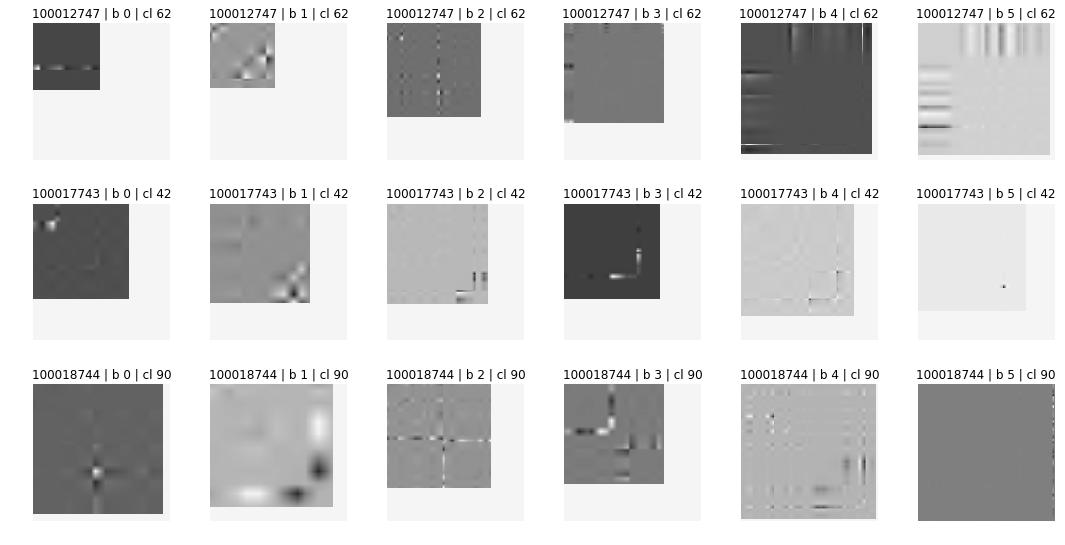

In [7]:
fig = plt.figure(figsize=(15,25))

for t,data_t in (enumerate(data)):
# t = target index
    
    for band in range(data_t.shape[2]):
    # iterating over the bands for target t
    # (they could in principle be different for different targets)

        band = int(band)
        
        image_t_b = data[t,:,:,band]
        # image corresponding to a given target t and band

        # Plotting:

        p = t*6 + band
        # p = plot counter
        
        plt.subplot(10, 6, p + 1)
        plt.axis('off')

        plt.tight_layout()

        plt.imshow(image_t_b, cmap=plt.cm.gray_r, vmin=-0.05, vmax=1.2, interpolation='nearest')
        plt.title(str(IDs_unique[t]) + ' | b ' + str(band) + ' | cl ' + labels_unique[t])
        
    if p == 17: break


## Creating samples


In [8]:
# Shuffle the samples
shuffled_indexes = np.arange(len(IDs_unique))
np.random.shuffle(shuffled_indexes)

# To reduce the sample size (for testing purposes):
# remove: shuffled_indexes = shuffled_indexes[0:1000]
# remove: n_samples = len(shuffled_indexes)

data = data[shuffled_indexes]
labels_unique = list(np.array(labels_unique)[shuffled_indexes])

n_samples = len(IDs_unique)

# purging memory from variabls not used anymore
del series

In [9]:
# Splitting in training, validation, and test samples:
data_train = data[:8 * n_samples // 10] # i.e. 80% training
labels_train = labels_unique[:8 * n_samples // 10]

data_valid = data[8 * n_samples // 10:9 * n_samples // 10] # i.e. 10% validation (80->90%)
labels_valid = labels_unique[8 * n_samples // 10:9 * n_samples // 10]

data_test = data[9 * n_samples // 10:] # i.e. 10% testing (90->100%)
labels_test = labels_unique[9 * n_samples // 10:]

#n_train_spiral = len([x for x in labels_train if x == 'spiral'])
#n_train_ellipt = len([x for x in labels_train if x == 'ellipt'])

#n_valid_spiral = len([x for x in labels_valid if x == 'spiral'])
#n_valid_ellipt = len([x for x in labels_valid if x == 'ellipt'])

#n_test_spiral = len([x for x in labels_test if x == 'spiral'])
#n_test_ellipt = len([x for x in labels_test if x == 'ellipt'])

print("Sample Summary")
print("________________________")
print("Total images     | %5s" % len(data))
print("-----------------|------")
print(" '-> Training    | %5s" % len(data_train))
#print("      '-> spiral | %5s (%.1f%%)" % (n_train_spiral , (n_train_spiral/len(data_train)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_train_ellipt , (n_train_ellipt/len(data_train)*100.)))
print("-----------------|------")
print(" '-> Validation  | %5s" % len(data_valid))
#print("      '-> spiral | %5s (%.1f%%)" % (n_valid_spiral , (n_valid_spiral/len(data_valid)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_valid_ellipt , (n_valid_ellipt/len(data_valid)*100.)))
print("-----------------|------")
print(" '-> Test        | %5s" % len(data_test))
#print("      '-> spiral | %5s (%.1f%%)" % (n_test_spiral , (n_test_spiral/len(data_test)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_test_ellipt , (n_test_ellipt/len(data_test)*100.)))

print('')
print('Compare these values with the accuracy of each classifier')
print('If accuracies are similar to the demographics, the classifier is only mirroring the data')

Sample Summary
________________________
Total images     |    17
-----------------|------
 '-> Training    |    13
-----------------|------
 '-> Validation  |     2
-----------------|------
 '-> Test        |     2

Compare these values with the accuracy of each classifier
If accuracies are similar to the demographics, the classifier is only mirroring the data


## 5) Building a Keras Neural Network classifier


In [10]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Convolution1D
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Dropout

from tensorflow.contrib.layers import maxout

from keras.utils import np_utils
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [46]:
n_bands = data_train.shape[-1]

# >> One hot encoding the class values to tranform the vector of class integers into a binary matrix:
int_enc = LabelEncoder()
labels_train_int = int_enc.fit_transform(labels_train)
labels_valid_int = int_enc.fit_transform(labels_valid)
labels_test_int  = int_enc.fit_transform(labels_test)

# Replicating the classification for all the bands:
labels_train_int = np.repeat(labels_train_int[:,np.newaxis], n_bands, 1)
labels_valid_int = np.repeat(labels_valid_int[:,np.newaxis], n_bands, 1)
labels_test_int  = np.repeat(labels_test_int[:,np.newaxis], n_bands, 1)

oh_enc = OneHotEncoder(sparse=False)
labels_train_ohe = oh_enc.fit_transform(labels_train_int)
labels_valid_ohe = oh_enc.fit_transform(labels_valid_int)
labels_train_ohe = oh_enc.fit_transform(labels_test_int)

# uniques, labels_valid = np.unique(labels_valid, return_inverse=True)
labels_train_cat = np_utils.to_categorical(labels_train_int)
labels_valid_cat = np_utils.to_categorical(labels_valid_int)
labels_test_cat  = np_utils.to_categorical(labels_test_int)

#n_classes = labels_valid_ohe.shape[1]
n_classes = 15
# must hard-code this one

print("Train      int label format (?, ?, n_samples, n_channels)         | ", labels_train_int.shape)
print("Validation int label format (?, ?, n_samples, n_channels)         | ", labels_valid_int.shape)
print("Test       int label format (?, ?, n_samples, n_channels)         | ", labels_test_int.shape)

Train      int label format (?, ?, n_samples, n_channels)         |  (13, 6)
Validation int label format (?, ?, n_samples, n_channels)         |  (2, 6)
Test       int label format (?, ?, n_samples, n_channels)         |  (2, 6)


In [47]:
n_pixels = data_train.shape[1] 

# Formatting data for convolutional layer:
n_train_targets = data_train.shape[0]
n_valid_targets = data_valid.shape[0]
n_test_targets  = data_test.shape[0]

labels_train_int_4D = np.expand_dims(labels_train_int   , axis=0)
labels_train_int_4D = np.expand_dims(labels_train_int_4D, axis=0)
labels_valid_int_4D = np.expand_dims(labels_valid_int   , axis=0)
labels_valid_int_4D = np.expand_dims(labels_valid_int_4D, axis=0)
labels_test_int_4D  = np.expand_dims(labels_test_int    , axis=0)
labels_test_int_4D  = np.expand_dims(labels_test_int_4D , axis=0)


print("Data/Label formats for convolutional layers:")

print("Train      4D data format (n_samples,size_x, size_y, n_channels) | ", data_train.shape)
print("Validation 4D data format (n_samples,size_x, size_y, n_channels) | ", data_valid.shape)
print("Test       4D data format (n_samples,size_x, size_y, n_channels) | ", data_test.shape)

print("Train      4D label format (?, ?, n_samples, n_channels)         | ", labels_train_int_4D.shape)
print("Validation 4D label format (?, ?, n_samples, n_channels)         | ", labels_valid_int_4D.shape)
print("Test       4D label format (?, ?, n_samples, n_channels)         | ", labels_test_int_4D.shape)

Data/Label formats for convolutional layers:
Train      4D data format (n_samples,size_x, size_y, n_channels) |  (13, 256, 256, 6)
Validation 4D data format (n_samples,size_x, size_y, n_channels) |  (2, 256, 256, 6)
Test       4D data format (n_samples,size_x, size_y, n_channels) |  (2, 256, 256, 6)
Train      4D label format (?, ?, n_samples, n_channels)         |  (1, 1, 13, 6)
Validation 4D label format (?, ?, n_samples, n_channels)         |  (1, 1, 2, 6)
Test       4D label format (?, ?, n_samples, n_channels)         |  (1, 1, 2, 6)


### Convolutional 2D layers

Not working with 'mean_squared_error' loss 

Loss function gets stuck when using 'softmax' activation

In [56]:
# Best so far (97% accuracy on test):
#
#model_Conv = keras.Sequential([
#                          keras.layers.Conv2D(8, kernel_size=(4,4), strides=(2,2), padding='same',
#                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,1)),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          #keras.layers.Dropout(0.3),
#                          keras.layers.Flatten(),
#                          keras.layers.Dense(10, activation=tf.nn.sigmoid),
#                          keras.layers.Dropout(0.3),
#                          keras.layers.Dense(n_classes, activation=tf.nn.sigmoid)
#                          ])

model_Conv = keras.Sequential([
                          keras.layers.Conv2D(8, kernel_size=(4,4), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,n_bands),
                                              data_format="channels_last"),
                          #keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          #keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
                          #                    activation=tf.nn.relu),
                          #keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          #keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
                          #                    activation=tf.nn.relu),
                          #keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          ##keras.layers.Dropout(0.3),
                          #keras.layers.Flatten(),
                          #keras.layers.Dense(20, activation=tf.nn.sigmoid, input_shape=(784,)),
                          #keras.layers.Dropout(0.3),
                          #keras.layers.Dense(n_classes, activation=tf.nn.sigmoid)
                          ])

model_Conv.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_Conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 8)       776       
Total params: 776
Trainable params: 776
Non-trainable params: 0
_________________________________________________________________


In [57]:
# restore: history_Conv = model_Conv.fit(data_train, labels_train_int, validation_data=(data_valid, labels_valid_int),
#                    epochs=30, batch_size=100, verbose=2)

history_Conv = model_Conv.fit(data_train, labels_train_int_4D, epochs=5, batch_size=1, verbose=2)

ValueError: Error when checking target: expected conv2d_8 to have shape (256, 256, 1) but got array with shape (1, 13, 6)

In [50]:
# > Model evolution:
plt.plot(history_Conv.history['loss'])
plt.plot(history_Conv.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# > Comparison with predictions:
labels_pred_float_Conv = model_Conv.predict(data_test_4D)

labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
# reversing one hot encoding


print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))


# > Plotting a few misclassified images (wrong labels):

print('Examples of misclassified images:')

indexes_wrong = np.nonzero(labels_pred_Conv != labels_test)
# equivalent: indexes_wrong = [labels_pred_Conv != labels_test]
# indexes of misclassified objects <indexed within range(data_test) or range(labels_pred_*)>

labels_pred_int_Conv = labels_pred_float_Conv.argmax(1)

data_test_wrong            = data_test[indexes_wrong]
labels_test_int_wrong      = labels_test_int[indexes_wrong]
labels_pred_int_Conv_wrong = labels_pred_int_Conv[indexes_wrong]


fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=0.25,wspace=0.05)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    image_wrong = (data_test_wrong[i].reshape(n_pixels,n_pixels))
    plt.imshow(image_wrong, cmap=plt.cm.gray_r, vmin=np.min(image_wrong), vmax=0.25*np.max(image_wrong), interpolation='nearest')
    plt.title('label = %s | pred = %s' % (labels_test_int_wrong[i][0] , labels_pred_int_Conv_wrong[i]))



NameError: name 'history_Conv' is not defined

https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

## 5) Using Tensorflow
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network_raw.ipynb

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

## Final check 
Using the test sample for a final check of the various algorithms used above. 

Checking if their performance is as good as it is reported in the validation process.

In [51]:
print("====================================================================================")
# Predictions for SVM:
predicted = model_svc.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_svc, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for LogisticRegression:
predicted = model_svc.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_lrc, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for MLP:
predicted = model_MLP.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_MLP, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for RandomForests:
predicted = model_RF.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_RF, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for Keras 1D Neural Network:
labels_pred_float_1D = model_1D.predict(data_test)
labels_pred_1D = int_enc.inverse_transform(labels_pred_float_1D.argmax(1))
print("Classification report for %s:\n%s\n"
      % (model_1D, metrics.classification_report(labels_test, labels_pred_1D)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_1D))
print("====================================================================================")

# Predictions for Keras Convolutional Neural Network:
labels_pred_float_Conv = model_Conv.predict(data_test_4D)
labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))
print("====================================================================================")

NameError: name 'model_svc' is not defined

# Saving the trained models
Using pickle we can save the trained models to use them in a later time w/o the need to re-train them.

In [52]:
import pickle
import os

# saving the models to disk
folder_saved = "saved_models/v1"

model_labels = ['SVC','LogReg','MLP','RandFor','Ker_1D','Ker_Conv']
models = ['model_SVC','model_LR','model_MLP','model_RF','model_1D','model_Conv']

if not os.path.exists(folder_saved):
    os.makedirs(folder_saved)
    
for modstr,model in zip(model_labels,models):
    pickle.dump(model, open(folder_saved+'/galaxy_classification_SDSS_v1_'+modstr+'.sav', 'wb'))


# To load the models at a later time:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)